In [ ]:
# Single Query Single Answer
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import ast
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
from keras.utils import plot_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

mkqa_dataset=[]
with open(file='mkqa.json',mode='r',encoding='utf-8') as file1:
    for item in file1:
        try:
            mkqa_dataset.append(ast.literal_eval(item))
        except:
            continue

pd.DataFrame(mkqa_dataset).to_csv('input_data_ss.csv',index=False)

mkqa_dataset=mkqa_dataset[20:800]
# Single Query Single Answer
all_set_ques=[]
correct_all_set_answ=[]
in_correct_all_set_answ=[]
correct_lang=['en','ar','fi','ja','ko','ru','tr','hu','nl','de']
in_correct_lang=['da','es','fr','it','ms','no','pl','pt','sv','vi']

for item in range(len(mkqa_dataset)):
    for lang1 in range(len(correct_lang)):
        q_lang1=mkqa_dataset[item]['queries'][correct_lang[lang1]].replace(':','').lower().strip()
        for lang2 in range(len(in_correct_lang)):
            all_set_ques.append(q_lang1)
            correct_all_set_answ.append(mkqa_dataset[item]['answers'][correct_lang[lang2]][0]['text'].replace(':','').lower().strip())
            in_correct_all_set_answ.append(mkqa_dataset[item]['queries'][in_correct_lang[lang2]].replace(':','').lower().strip())

dataset1=pd.DataFrame()
dataset1['Query']=all_set_ques
dataset1['Correct Document']=correct_all_set_answ
dataset1['In Correct Document']=in_correct_all_set_answ
dataset1.to_csv('processed_data_ss.csv',index=False)
del dataset1

embedding_dim=32
correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,correct_all_set_answ)]
in_correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,in_correct_all_set_answ)]
combined_data=correct_ans_data + in_correct_ans_data
del correct_ans_data,in_correct_ans_data

with open(file="model_data_ss.txt",mode="w") as file1:
    for item in combined_data:
        file1.write("%s\n"%item)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(combined_data)
sequences=tokenizer.texts_to_sequences(combined_data)
padded_sequences=pad_sequences(sequences,padding='post')
labels=[1] * len(correct_all_set_answ) + [0] * len(in_correct_all_set_answ)
labels=np.array(labels)

with open(file="model_tokenizer_ss.pkl",mode="wb") as file1:
    pickle.dump(tokenizer,file1)
# with open(file="model_tokenizer_ss.pkl",mode="rb") as file1:
#     tokenizer=pickle.load(file1)

with open(file="model_padded_sequences_ss.pkl",mode="wb") as file1:
    pickle.dump(padded_sequences,file1)
# with open(file="model_padded_sequences_ss.pkl",mode="rb") as file1:
#     padded_sequences=pickle.load(file1)

with open(file="model_labels_ss.pkl",mode="wb") as file1:
    pickle.dump(labels,file1)
# with open(file="model_labels_ss.pkl",mode="rb") as file1:
#     labels=pickle.load(file1)

input_layer=Input(shape=(padded_sequences.shape[1],))
embedding_layer=Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=embedding_dim)(input_layer)
x=GlobalAveragePooling1D()(embedding_layer)
x=Bidirectional(LSTM(8))(embedding_layer)
x=Dropout(rate=0.2)(x)
x=Dense(embedding_dim)(x)
output_layer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input_layer,outputs=output_layer)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[Recall()])
history=model.fit(padded_sequences,labels,epochs=3,batch_size=32,validation_split=0.2,verbose=1)
model.save('embed_creation_model_ss.keras')
# model=load_model('embed_creation_model_ss.keras')

plot_model(
    model,
    to_file='model_plot_ss.png',
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    )

embedding_model=Model(inputs=model.input,outputs=model.layers[-2].output)
embedding_model.save('embedding_model_ss.keras')
# embedding_model=load_model('embedding_model_ss.keras')
train_embeddings=embedding_model.predict(padded_sequences)
with open(file="train_embeddings_ss.pkl",mode="wb") as file1:
    pickle.dump(train_embeddings,file1)
# with open(file="train_embeddings_ss.pkl",mode="rb") as file1:
#     train_embeddings=pickle.load(file1)

# Train 3 Different Algorithms

nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)

annoy_index=AnnoyIndex(embedding_dim,metric='angular')
for i,emb in enumerate(train_embeddings):
    annoy_index.add_item(i,emb.tolist())
annoy_index.build(10)

hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)

with open(file="nearest_neighbors_model_ss.pkl",mode="wb") as file1:
    pickle.dump(nn_emb,file1)
# with open(file="nearest_neighbors_model_ss.pkl",mode="rb") as file1:
#     nn_emb=pickle.load(file1)

annoy_index.save('annoy_model_ss.ann')
# annoy_index=AnnoyIndex(embedding_dim,metric='angular')
# annoy_index.load('annoy_model_ss.ann')

with open(file="hnswlib_model_ss.pkl",mode="wb") as file1:
    pickle.dump(hnsw_index,file1)
# with open(file="hnswlib_model_ss.pkl",mode="rb") as file1:
#     hnsw_index=pickle.load(file1)

test_samples=[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,40,41,228,458]

with open(file="test_cases_ss.pkl",mode="wb") as file1:
    pickle.dump(test_samples,file1)
# with open(file="test_cases_ss.pkl",mode="rb") as file1:
#     test_samples=pickle.load(file1)

# Inclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [1,2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1=pd.DataFrame()
df1['Index_IDS']=index_ids
df1['NearestNeighbors']=nn_t
df1['AnnoyIndex']=annoy_t
df1['HNSWLib']=hnsw_t
df1['Best_Of_3']=best_of_3
df1['Neighbours']=neigh_val
df1['SUM']=df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())
print(tabulate(df1,headers='keys',tablefmt='github'))



# Exclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df2=pd.DataFrame()
df2['Index_IDS']=index_ids
df2['NearestNeighbors']=nn_t
df2['AnnoyIndex']=annoy_t
df2['HNSWLib']=hnsw_t
df2['Best_Of_3']=best_of_3
df2['Neighbours']=neigh_val
df2['SUM']=df2['NearestNeighbors'] + df2['AnnoyIndex'] + df2['HNSWLib'] + df2['Best_Of_3']
print('Current Overall Recall : ',(1-(df2[df2['SUM']<4].shape[0] / df2.shape[0]))*100)
print(df2[df2['SUM']<4].shape[0],df2.shape[0])
print(df2[df2['SUM']<4]['Neighbours'].unique())
print(tabulate(df2,headers='keys',tablefmt='github'))

Epoch 1/3
3900/3900 [==============================] - 118s 29ms/step - loss: 0.0183 - recall: 0.9979 - val_loss: 0.1212 - val_recall: 0.0000e+00
Epoch 2/3
3900/3900 [==============================] - 112s 29ms/step - loss: 8.8551e-04 - recall: 0.9998 - val_loss: 0.1527 - val_recall: 0.0000e+00
Epoch 3/3
4875/4875 [==============================] - 31s 6ms/step
Test Samples Index :  1
1/1 [==============================] - 1s 816ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 27ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 27ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 28ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  3
1/1

In [ ]:
print(df1[df1['NearestNeighbors']==0].shape[0]/df1.shape[0],df1[df1['AnnoyIndex']==0].shape[0]/df1.shape[0],df1[df1['HNSWLib']==0].shape[0]/df1.shape[0],df1[df1['Best_Of_3']==0].shape[0]/df1.shape[0])

0.0 0.075 0.0125 0.075


In [ ]:
print(df2[df2['NearestNeighbors']==0].shape[0]/df2.shape[0],df2[df2['AnnoyIndex']==0].shape[0]/df2.shape[0],df2[df2['HNSWLib']==0].shape[0]/df2.shape[0],df2[df2['Best_Of_3']==0].shape[0]/df2.shape[0])

0.0 0.03333333333333333 0.0 0.03333333333333333


In [ ]:
# Single Query Multiple Answers
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import ast
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
from keras.utils import plot_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

mkqa_dataset=[]
with open(file='mkqa.json',mode='r',encoding='utf-8') as file1:
    for item in file1:
        try:
            mkqa_dataset.append(ast.literal_eval(item))
        except:
            continue

pd.DataFrame(mkqa_dataset).to_csv('input_data_sms.csv',index=False)

mkqa_dataset=mkqa_dataset[20:800]
# Single Query Multiple Answers
all_set_ques=[]
correct_all_set_answ=[]
in_correct_all_set_answ=[]
correct_lang=['en','ar','fi','ja','ko','ru','tr','hu','nl','de']
in_correct_lang=['da','es','fr','it','ms','no','pl','pt','sv','vi']
for item in range(len(mkqa_dataset)):
    for lang1 in range(len(correct_lang)):
        corr=[]
        incorr=[]
        q_lang1=mkqa_dataset[item]['queries'][correct_lang[lang1]].replace(':','').lower().strip()
        all_set_ques.append(q_lang1)
        for lang1 in range(len(correct_lang)):
            corr.append(mkqa_dataset[item]['answers'][correct_lang[lang1]][0]['text'].replace(':','').lower().strip())
        corr=' '.join(set(corr))
        correct_all_set_answ.append(corr)
        for lang2 in range(len(in_correct_lang)):
            incorr.append(mkqa_dataset[item]['queries'][in_correct_lang[lang2]].replace(':','').lower().strip())
        incorr=' '.join(set(incorr))
        in_correct_all_set_answ.append(incorr)

dataset1=pd.DataFrame()
dataset1['Query']=all_set_ques
dataset1['Correct Document']=correct_all_set_answ
dataset1['In Correct Document']=in_correct_all_set_answ
dataset1.to_csv('processed_data_sms.csv',index=False)
del dataset1

embedding_dim=32
correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,correct_all_set_answ)]
in_correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,in_correct_all_set_answ)]
combined_data=correct_ans_data + in_correct_ans_data
del correct_ans_data,in_correct_ans_data

with open(file="model_data_sms.txt",mode="w") as file1:
    for item in combined_data:
        file1.write("%s\n"%item)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(combined_data)
sequences=tokenizer.texts_to_sequences(combined_data)
padded_sequences=pad_sequences(sequences,padding='post')
labels=[1] * len(correct_all_set_answ) + [0] * len(in_correct_all_set_answ)
labels=np.array(labels)

with open(file="model_tokenizer_sms.pkl",mode="wb") as file1:
    pickle.dump(tokenizer,file1)
# with open(file="model_tokenizer_sms.pkl",mode="rb") as file1:
#     tokenizer=pickle.load(file1)

with open(file="model_padded_sequences_sms.pkl",mode="wb") as file1:
    pickle.dump(padded_sequences,file1)
# with open(file="model_padded_sequences_sms.pkl",mode="rb") as file1:
#     padded_sequences=pickle.load(file1)

with open(file="model_labels_sms.pkl",mode="wb") as file1:
    pickle.dump(labels,file1)
# with open(file="model_labels_sms.pkl",mode="rb") as file1:
#     labels=pickle.load(file1)

input_layer=Input(shape=(padded_sequences.shape[1],))
embedding_layer=Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=embedding_dim)(input_layer)
x=GlobalAveragePooling1D()(embedding_layer)
x=Bidirectional(LSTM(8))(embedding_layer)
x=Dropout(rate=0.2)(x)
x=Dense(embedding_dim)(x)
output_layer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input_layer,outputs=output_layer)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[Recall()])
history=model.fit(padded_sequences,labels,epochs=3,batch_size=32,validation_split=0.2,verbose=1)
model.save('embed_creation_model_sms.keras')
# model=load_model('embed_creation_model_sms.keras')

plot_model(
    model,
    to_file='model_plot_sms.png',
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    )

embedding_model=Model(inputs=model.input,outputs=model.layers[-2].output)
embedding_model.save('embedding_model_sms.keras')
# embedding_model=load_model('embedding_model_sms.keras')
train_embeddings=embedding_model.predict(padded_sequences)
with open(file="train_embeddings_sms.pkl",mode="wb") as file1:
    pickle.dump(train_embeddings,file1)
# with open(file="train_embeddings_sms.pkl",mode="rb") as file1:
#     train_embeddings=pickle.load(file1)

# Train 3 Different Algorithms

nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)

annoy_index=AnnoyIndex(embedding_dim,metric='angular')
for i,emb in enumerate(train_embeddings):
    annoy_index.add_item(i,emb.tolist())
annoy_index.build(10)

hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)

with open(file="nearest_neighbors_model_sms.pkl",mode="wb") as file1:
    pickle.dump(nn_emb,file1)
# with open(file="nearest_neighbors_model_sms.pkl",mode="rb") as file1:
#     nn_emb=pickle.load(file1)

annoy_index.save('annoy_model_sms.ann')
# annoy_index=AnnoyIndex(embedding_dim,metric='angular')
# annoy_index.load('annoy_model_sms.ann')

with open(file="hnswlib_model_sms.pkl",mode="wb") as file1:
    pickle.dump(hnsw_index,file1)
# with open(file="hnswlib_model_sms.pkl",mode="rb") as file1:
#     hnsw_index=pickle.load(file1)

test_samples=[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,40,41,228,458]

with open(file="test_cases_sms.pkl",mode="wb") as file1:
    pickle.dump(test_samples,file1)
# with open(file="test_cases_sms.pkl",mode="rb") as file1:
#     test_samples=pickle.load(file1)

# Inclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [1,2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1=pd.DataFrame()
df1['Index_IDS']=index_ids
df1['NearestNeighbors']=nn_t
df1['AnnoyIndex']=annoy_t
df1['HNSWLib']=hnsw_t
df1['Best_Of_3']=best_of_3
df1['Neighbours']=neigh_val
df1['SUM']=df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())
print(tabulate(df1,headers='keys',tablefmt='github'))



# Exclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df2=pd.DataFrame()
df2['Index_IDS']=index_ids
df2['NearestNeighbors']=nn_t
df2['AnnoyIndex']=annoy_t
df2['HNSWLib']=hnsw_t
df2['Best_Of_3']=best_of_3
df2['Neighbours']=neigh_val
df2['SUM']=df2['NearestNeighbors'] + df2['AnnoyIndex'] + df2['HNSWLib'] + df2['Best_Of_3']
print('Current Overall Recall : ',(1-(df2[df2['SUM']<4].shape[0] / df2.shape[0]))*100)
print(df2[df2['SUM']<4].shape[0],df2.shape[0])
print(df2[df2['SUM']<4]['Neighbours'].unique())
print(tabulate(df2,headers='keys',tablefmt='github'))

Epoch 1/3
390/390 [==============================] - 41s 91ms/step - loss: 0.1208 - recall_1: 0.9982 - val_loss: 0.0014 - val_recall_1: 0.0000e+00
Epoch 2/3
390/390 [==============================] - 36s 91ms/step - loss: 9.6635e-04 - recall_1: 1.0000 - val_loss: 2.6541e-04 - val_recall_1: 0.0000e+00
Epoch 3/3
488/488 [==============================] - 9s 17ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 45ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 30ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 33ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 35ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 36ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 36ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 32ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 30ms/step
Test Samples Index :  3


In [ ]:
print(df1[df1['NearestNeighbors']==0].shape[0]/df1.shape[0],df1[df1['AnnoyIndex']==0].shape[0]/df1.shape[0],df1[df1['HNSWLib']==0].shape[0]/df1.shape[0],df1[df1['Best_Of_3']==0].shape[0]/df1.shape[0])

0.0 0.0 0.0 0.0


In [ ]:
print(df2[df2['NearestNeighbors']==0].shape[0]/df2.shape[0],df2[df2['AnnoyIndex']==0].shape[0]/df2.shape[0],df2[df2['HNSWLib']==0].shape[0]/df2.shape[0],df2[df2['Best_Of_3']==0].shape[0]/df2.shape[0])

0.0 0.0 0.0 0.0


In [ ]:
pip install annoy hnswlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552448 sha256=2f598105bc7f894077968963d9d8af9b1bf9de34ab0520cbd203fe3ce32be4e5
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
  Created wheel for hnswlib: filename=hnswlib-0.8.0-cp310-cp310-linux_x86_64.whl size=2287620 sha256=4179a2d138ef4e3fb932f9f7ca591ab9de56308eb53ae43262809e93516b2b43
  Stored in directory: /root/.cache/pip/wheels/af/a9/3e/3e5d59ee41664eb31a4e6de67d1846f86d16d93c45f277c4e7
Successfully built annoy hnswlib


In [ ]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import ast
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
mkqa_dataset = []

with open(file='mkqa.json', mode='r', encoding='utf-8') as file1:
    for item in file1:
        try:
            mkqa_dataset.append(ast.literal_eval(item))
        except:
            continue


In [ ]:
pd.DataFrame(mkqa_dataset)

,query,answers,queries,example_id
0,how long did it take the twin towers to be built,"{'en': [{'type': 'number_with_unit', 'text': '...",{'tr': 'ikiz kulelerin inşa edilmesi ne kadar ...,3051930912491995402
1,who sings love you like there's no tomorrow,"{'en': [{'type': 'entity', 'entity': 'Q952176'...",{'tr': 'love you like there's no tomorrow'u ki...,-4766029169354683727
2,how many seasons of scream queens are there,"{'en': [{'type': 'number', 'text': '2.0', 'ali...",{'tr': 'Scream Queens dizisi kaç sezondan oluş...,-5007314435785513023
3,when was the last time the lakers made the pla...,"{'en': [{'type': 'date', 'text': '2013', 'alia...",{'tr': 'lakers'ın play-off yaptığı son zaman n...,7960403399608384663
4,how many episodes in a season of stranger things,"{'en': [{'type': 'number', 'text': '3.0', 'ali...",{'tr': 'stranger things'in bir sezonunda kaç b...,-6261874607090673789
...,...,...,...,...
853,who sang these boots are made for walkin,"{'en': [{'type': 'entity', 'entity': 'Q233937'...",{'tr': 'these boots are made for walkin şarkıs...,3146777178148103274
854,who was the first pope in the bible,"{'en': [{'type': 'entity', 'entity': 'Q33923',...","{'tr': 'İncil'e göre ilk papa kimdi?', 'hu': '...",753464263966516344
855,who won the most gold in the olympics,"{'en': [{'type': 'entity', 'entity': 'Q39562',...",{'tr': 'olimpiyatlarda en fazla altını kim kaz...,7135956910125091353
856,how many miles is washington dc from new york ...,"{'en': [{'type': 'number_with_unit', 'text': '...",{'tr': 'new york city den washington dc kaç mi...,7820599431684065938


Here we initializes three empty lists: all_set_ques, correct_all_set_answ, and in_correct_all_set_answ. These lists are intended to store all questions as well as the correct and the incorrect ones

In [ ]:
all_set_ques=[]
correct_all_set_answ=[]
in_correct_all_set_answ=[]

We are working on 10 languages and given a query can retrieve answer in any of the below languages

In [ ]:
correct_lang=['en','ar','fi','ja','ko','ru','tr','hu','nl','de']

Answers should not come from the below languages as we assume them to be irrelevant documents for our model

In [ ]:
in_correct_lang=['da','es','fr','it','ms','no','pl','pt','sv','vi']

Here we are iterating through the mkqa_dataset to extract and process information for creating three separate lists: all_set_ques, correct_all_set_answ, and in_correct_all_set_answ.

In [ ]:
for item in range(len(mkqa_dataset)):
    for lang1 in range(len(correct_lang)):
        q_lang1=mkqa_dataset[item]['queries'][correct_lang[lang1]].replace(':','').lower().strip()
        for lang2 in range(len(in_correct_lang)):
            all_set_ques.append(q_lang1)
            correct_all_set_answ.append(mkqa_dataset[item]['answers'][correct_lang[lang2]][0]['text'].replace(':','').lower().strip())
            in_correct_all_set_answ.append(mkqa_dataset[item]['queries'][in_correct_lang[lang2]].replace(':','').lower().strip())

In [ ]:
df0.tail()

NameError: ignored

In [ ]:
df0 = pd.DataFrame()
df0['Query']=all_set_ques
df0['Correct Answers / Document']=correct_all_set_answ
df0['InCorrect Answers / Document']=in_correct_all_set_answ
df0.tail()

,Query,Correct Answers / Document,InCorrect Answers / Document
85795,wer hat these boots are made for walking gesungen,"синатра, нэнси",hvem sang these boots are made for walking
85796,wer hat these boots are made for walking gesungen,nancy sinatra,"kto śpiewał ""these boots are made for walking"""
85797,wer hat these boots are made for walking gesungen,nancy sinatra,quem cantava these boots are made for walking?
85798,wer hat these boots are made for walking gesungen,nancy sinatra,vem sjöng these boots are made for walking
85799,wer hat these boots are made for walking gesungen,nancy sinatra,ai đã hát bài hát these boots are made for wal...


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Correct Answers / Document').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('InCorrect Answers / Document').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Correct Answers / Document')):
  _plot_series(series, series_name, i)
  fig.legend(title='Correct Answers / Document', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('InCorrect Answers / Document')):
  _plot_series(series, series_name, i)
  fig.legend(title='InCorrect Answers / Document', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['InCorrect Answers / Document'].value_counts()
    for x_label, grp in _df_6.groupby('Correct Answers / Document')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Correct Answers / Document')
_ = plt.ylabel('InCorrect Answers / Document')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_7['Correct Answers / Document'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_7, x='index', y='Correct Answers / Document', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_8['InCorrect Answers / Document'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_8, x='index', y='InCorrect Answers / Document', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

Text processing by concatenating question-answer pairs from two lists and storing them in a combined list

In [ ]:
embedding_dim = 32
correct_ans_data = [q + ' ' + ' '.join(ans) for q, ans in zip(all_set_ques, correct_all_set_answ)]
in_correct_ans_data = [q + ' ' + ' '.join(ans) for q, ans in zip(all_set_ques, in_correct_all_set_answ)]
combined_data = correct_ans_data + in_correct_ans_data
del correct_ans_data, in_correct_ans_data

## Pre-processing the Data
 Text tokenization and sequence padding to be done for the model

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(combined_data)
sequences = tokenizer.texts_to_sequences(combined_data)
padded_sequences = pad_sequences(sequences, padding='post')
labels = [1] * len(correct_all_set_answ) + [0] * len(in_correct_all_set_answ)
labels = np.array(labels)

## Model Architecture
Creating and training a neural network model for a binary text classification task. It begins by defining layers for input, embedding, LSTM (Long Short-Term Memory), and dense (fully connected) layers. Training occurs over two epochs, with a batch size of 32 and 20% of the data used for validation.

In [ ]:
input_layer = Input(shape=(padded_sequences.shape[1],))
embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim)(input_layer)
x = GlobalAveragePooling1D()(embedding_layer)
x = Bidirectional(LSTM(8))(embedding_layer)
x = Dropout(rate=0.2)(x)
x = Dense(embedding_dim)(x)
output_layer = Dense(1, activation='sigmoid')(x)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Recall()])
history = model.fit(padded_sequences, labels, epochs=3, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/3
4290/4290 [==============================] - 287s 66ms/step - loss: 0.0288 - recall_1: 0.9944 - val_loss: 0.0520 - val_recall_1: 0.0000e+00
Epoch 2/3
4290/4290 [==============================] - 278s 65ms/step - loss: 0.0045 - recall_1: 0.9988 - val_loss: 0.0686 - val_recall_1: 0.0000e+00
Epoch 3/3
4290/4290 [==============================] - 281s 65ms/step - loss: 0.0022 - recall_1: 0.9994 - val_loss: 0.1078 - val_recall_1: 0.0000e+00


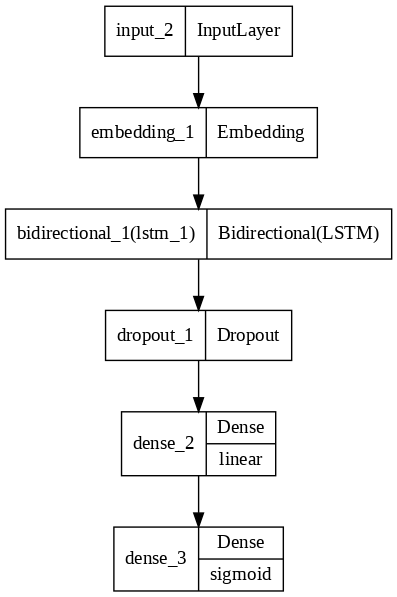

In [ ]:
from keras.utils import plot_model
plot_model(
    model,
    to_file='model_plot.png',
    # show_shapes=True,
    # show_dtype=True,
    # show_layer_names=True,
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    )

In [ ]:
embedding_model=Model(inputs=model.input,outputs=model.layers[-2].output)

 The 'embedding_model' is being used to predict embeddings for the provided 'padded_sequences'

In [ ]:
train_embeddings=embedding_model.predict(padded_sequences)

5363/5363 [==============================] - 89s 16ms/step


Here we chose the desired query for which we want to perform cross lingual information retrieval

In [ ]:
test_index=3
query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
print("Query: ",all_set_ques[test_index])

1/1 [==============================] - 0s 45ms/step
Query:  how long did it take the twin towers to be built


In [ ]:
nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)
distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=2)
nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",nearest_neighbors_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 年', '11.0 лет']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   л е т']


In [ ]:
nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)
distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=5)
nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",nearest_neighbors_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 年', '11.0 лет', '11.0 سنة', '11.0 연도', '55.0 67.0 английский фут']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   л е т', 'how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   연 도', 'how long is the average freight train car 5 5 . 0   6 7 . 0   а н г л и й с к и й   ф у т']


In [ ]:
annoy_index=AnnoyIndex(embedding_dim,metric='angular')
for i,emb in enumerate(train_embeddings):
    annoy_index.add_item(i,emb.tolist())
annoy_index.build(10)
indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=2)]
annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",annoy_index_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 年', '11.0 سنة']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   س ن ة']


In [ ]:
nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)
distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=5)
nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",nearest_neighbors_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 年', '11.0 лет', '11.0 سنة', '11.0 연도', '55.0 67.0 английский фут']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   л е т', 'how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   연 도', 'how long is the average freight train car 5 5 . 0   6 7 . 0   а н г л и й с к и й   ф у т']


In [ ]:
hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)
indices,distances=hnsw_index.knn_query(query_embedding,k=2)
hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",hnsw_index_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 سنة', '11.0 年']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   年']


In [ ]:
hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)
indices,distances=hnsw_index.knn_query(query_embedding,k=5)
hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]
print("Predictions values: ",hnsw_index_values)
print("Actual values: ",[combined_data[i] for i in indices[0]])

Predictions values:  ['11.0 سنة', '11.0 年', '11.0 лет', '11.0 연도', '55.0 67.0 voet']
Actual values:  ['how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   л е т', 'how long did it take the twin towers to be built 1 1 . 0   연 도', 'how long is the average freight train car 5 5 . 0   6 7 . 0   v o e t']


In [ ]:
from sklearn.metrics import classification_report

# Define the k values
k_values = [1, 2, 5]

# Store recall values in a dictionary
recall_values = {}

for k in k_values:
    indices, _ = hnsw_index.knn_query(query_embedding, k=k)
    predicted_labels = [1 if i in indices else 0 for i in range(len(train_embeddings))]
    true_labels = [1 if i in indices[0] else 0 for i in range(len(train_embeddings))]

    report = classification_report(true_labels, predicted_labels, target_names=['Not Nearest Neighbor', 'Nearest Neighbor'], output_dict=True)
    recall_values[f"Recall@{k}"] = report['Nearest Neighbor']['recall']

    # Printing predictions and actual values
    hnsw_index_values = [correct_all_set_answ[i] for i in indices[0]]
    print(f"Predictions values (k={k}): {hnsw_index_values}")
    actual_values = [combined_data[i] for i in indices[0]]
    print(f"Actual values (k={k}): {actual_values}")

# Print recall values in tabular format
print("\nRecall Values:")
print("{:<15} {:<10}".format("k Value", "Recall"))
print("-----------------------")
for k, v in recall_values.items():
    print("{:<15} {:.4f}".format(k, v))


Predictions values (k=1): ['11.0 سنة']
Actual values (k=1): ['how long did it take the twin towers to be built 1 1 . 0   س ن ة']
Predictions values (k=2): ['11.0 سنة', '11.0 年']
Actual values (k=2): ['how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   年']
Predictions values (k=5): ['11.0 سنة', '11.0 年', '11.0 лет', '11.0 연도', '55.0 67.0 voet']
Actual values (k=5): ['how long did it take the twin towers to be built 1 1 . 0   س ن ة', 'how long did it take the twin towers to be built 1 1 . 0   年', 'how long did it take the twin towers to be built 1 1 . 0   л е т', 'how long did it take the twin towers to be built 1 1 . 0   연 도', 'how long is the average freight train car 5 5 . 0   6 7 . 0   v o e t']

Recall Values:
k Value         Recall    
-----------------------
Recall@1        1.0000
Recall@2        1.0000
Recall@5        1.0000


In [ ]:
len(padded_sequences)

171600

In [ ]:
import pandas as pd

In [ ]:
index_ids = []
nn_t = []
annoy_t = []
hnsw_t = []

for test_index in range(20000):

    print('Current Index : ',test_index)

    index_ids.append(test_index)

    query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
    current_ans = correct_all_set_answ[test_index]

    distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=1)
    nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]][0]

    indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=1)]
    annoy_index_values=[correct_all_set_answ[i] for i in indices[0]][0]

    indices,distances=hnsw_index.knn_query(query_embedding,k=1)
    hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]][0]


    if current_ans==nearest_neighbors_values:
        nn_t.append(1)
    else:
        nn_t.append(0)

    if current_ans==annoy_index_values:
        annoy_t.append(1)
    else:
        annoy_t.append(0)

    if current_ans==hnsw_index_values:
        hnsw_t.append(1)
    else:
        hnsw_t.append(0)


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 58ms/step
Current Index :  12534
1/1 [==============================] - 0s 39ms/step
Current Index :  12535
1/1 [==============================] - 0s 42ms/step
Current Index :  12536
1/1 [==============================] - 0s 46ms/step
Current Index :  12537
1/1 [==============================] - 0s 39ms/step
Current Index :  12538
1/1 [==============================] - 0s 50ms/step
Current Index :  12539
1/1 [==============================] - 0s 54ms/step
Current Index :  12540
1/1 [==============================] - 0s 45ms/step
Current Index :  12541
1/1 [==============================] - 0s 51ms/step
Current Index :  12542
1/1 [==============================] - 0s 45ms/step
Current Index :  12543
1/1 [==============================] - 0s 42ms/step
Current Index :  12544
1/1 [==============================] - 0s 35ms/step
Current Index :  12545
1/1 [==============================] - 0s 47ms/st

IndexError: ignored

In [ ]:
df = pd.DataFrame()
df['Index_IDS'] = index_ids[0:15032]
df['NearestNeighbors'] = nn_t[0:15032]
df['AnnoyIndex'] = annoy_t[0:15032]
df['HNSWLib'] = hnsw_t[0:15032]
df['SUM'] = df['NearestNeighbors'] + df['AnnoyIndex'] + df['HNSWLib']

In [ ]:
df.head()

,Index_IDS,NearestNeighbors,AnnoyIndex,HNSWLib,SUM
0,0,1,1,1,3
1,1,1,0,1,2
2,2,1,1,1,3
3,3,1,1,0,2
4,4,1,1,1,3


In [ ]:
print('Current Overall Recall : ',(1-(df[df['SUM']<3].shape[0] / df.shape[0]))*100)

Current Overall Recall :  94.96407663650878


In [ ]:
df[df['SUM']<3].shape[0]

757

In [ ]:
df[df['SUM']<3]

,Index_IDS,NearestNeighbors,AnnoyIndex,HNSWLib,SUM
1,1,1,0,1,2
3,3,1,1,0,2
5,5,1,1,0,2
15,15,1,0,1,2
45,45,1,1,0,2
...,...,...,...,...,...
15004,15004,1,0,1,2
15012,15012,1,1,0,2
15014,15014,1,0,0,1
15024,15024,1,0,0,1


In [ ]:
df[df['SUM']<3]['Index_IDS'].values

array([    1,     3,     5,    15,    45,    51,    55,    61,    65,
          75,    81,    85,    93,    95,   105,   113,   115,   123,
         144,   145,   155,   163,   165,   175,   184,   185,   193,
         195,   505,   513,   515,   523,   525,   535,   543,   545,
         553,   555,   563,   565,   575,   593,   595,   603,   621,
         685,   693,   695,   890,   891,   892,   893,   894,   895,
         896,   897,   898,   899,   913,   983,  1061,  1105,  1113,
        1124,  1143,  1144,  1145,  1153,  1154,  1155,  1163,  1164,
        1165,  1173,  1174,  1175,  1183,  1184,  1185,  1193,  1194,
        1195,  1205,  1253,  1254,  1284,  1315,  1353,  1354,  1355,
        1375,  1384,  1385,  1393,  1457,  1486,  1505,  1515,  1554,
        1575,  1581,  1584,  1585,  1594,  1603,  1604,  1605,  1674,
        1683,  1703,  1725,  1765,  1773,  1785,  2025,  2041,  2075,
        2101,  2103,  2105,  2111,  2113,  2115,  2121,  2123,  2125,
        2131,  2135,

In [ ]:
test_sample_50_45=[4,44,1152,1145,1152,1156,1162,2132,2137,2144,2154,2160,2164,2165,2180,2184,2025,2041,2075,9982,9985,9991,9995,10047,10072,10108,10164,10201,12500,12502,12506,12506,12512,12517,12526,12529,13660,13663,13667,13674,13698,13712,13775,14010,14012]
test_sample_50_5=[5,1152,1456,2075,14923]

In [ ]:
test_sample_43_12=[44,1156,2132,9982,9995,10047,12500,12512,13660,12529,14010,14012]
test_sample_7_3=[5,2075,14923]
test_samples=test_sample_43_12+test_sample_7_3

In [ ]:
# Inclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [1,2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans = correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values = set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values = set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1 = pd.DataFrame()
df1['Index_IDS'] = index_ids
df1['NearestNeighbors'] = nn_t
df1['AnnoyIndex'] = annoy_t
df1['HNSWLib'] = hnsw_t
df1['Best_Of_3'] = best_of_3
df1['Neighbours'] = neigh_val
df1['SUM'] = df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())

Test Samples Index :  44
1/1 [==============================] - 0s 43ms/step
Test Samples Index :  44
1/1 [==============================] - 0s 51ms/step
Test Samples Index :  44
1/1 [==============================] - 0s 49ms/step
Test Samples Index :  44
1/1 [==============================] - 0s 42ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 43ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 45ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 57ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 95ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 69ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 60ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 59ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 77ms/step
Test Samples Index :  9982
1/1 [============================

In [ ]:
# Exclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans = correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values = set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values = set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1 = pd.DataFrame()
df1['Index_IDS'] = index_ids
df1['NearestNeighbors'] = nn_t
df1['AnnoyIndex'] = annoy_t
df1['HNSWLib'] = hnsw_t
df1['Best_Of_3'] = best_of_3
df1['Neighbours'] = neigh_val
df1['SUM'] = df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())

Test Samples Index :  44
1/1 [==============================] - 0s 91ms/step
Test Samples Index :  44
1/1 [==============================] - 0s 66ms/step
Test Samples Index :  44
1/1 [==============================] - 0s 113ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 55ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 54ms/step
Test Samples Index :  1156
1/1 [==============================] - 0s 57ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 49ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 66ms/step
Test Samples Index :  2132
1/1 [==============================] - 0s 67ms/step
Test Samples Index :  9982
1/1 [==============================] - 0s 49ms/step
Test Samples Index :  9982
1/1 [==============================] - 0s 46ms/step
Test Samples Index :  9982
1/1 [==============================] - 0s 39ms/step
Test Samples Index :  9995
1/1 [=========================

In [ ]:
pip install tabulate

In [ ]:
from tabulate import tabulate

In [ ]:
print(tabulate(df1,headers='keys',tablefmt='psql'))

+----+-------------+--------------------+--------------+-----------+-------------+--------------+-------+
|    |   Index_IDS |   NearestNeighbors |   AnnoyIndex |   HNSWLib |   Best_Of_3 |   Neighbours |   SUM |
|----+-------------+--------------------+--------------+-----------+-------------+--------------+-------|
|  0 |          44 |                  1 |            1 |         1 |           1 |            2 |     4 |
|  1 |          44 |                  1 |            1 |         1 |           1 |            5 |     4 |
|  2 |          44 |                  1 |            1 |         1 |           1 |           10 |     4 |
|  3 |        1156 |                  1 |            1 |         1 |           1 |            2 |     4 |
|  4 |        1156 |                  1 |            1 |         1 |           1 |            5 |     4 |
|  5 |        1156 |                  1 |            1 |         1 |           1 |           10 |     4 |
|  6 |        2132 |                  1 |     

In [ ]:
print(tabulate(df1,headers='keys',tablefmt='pretty'))

+----+-----------+------------------+------------+---------+-----------+------------+-----+
|    | Index_IDS | NearestNeighbors | AnnoyIndex | HNSWLib | Best_Of_3 | Neighbours | SUM |
+----+-----------+------------------+------------+---------+-----------+------------+-----+
| 0  |    44     |        1         |     1      |    1    |     1     |     2      |  4  |
| 1  |    44     |        1         |     1      |    1    |     1     |     5      |  4  |
| 2  |    44     |        1         |     1      |    1    |     1     |     10     |  4  |
| 3  |   1156    |        1         |     1      |    1    |     1     |     2      |  4  |
| 4  |   1156    |        1         |     1      |    1    |     1     |     5      |  4  |
| 5  |   1156    |        1         |     1      |    1    |     1     |     10     |  4  |
| 6  |   2132    |        1         |     1      |    1    |     1     |     2      |  4  |
| 7  |   2132    |        1         |     1      |    1    |     1     |     5  

In [ ]:
print(tabulate(df1,headers='keys',tablefmt='github'))

|    |   Index_IDS |   NearestNeighbors |   AnnoyIndex |   HNSWLib |   Best_Of_3 |   Neighbours |   SUM |
|----|-------------|--------------------|--------------|-----------|-------------|--------------|-------|
|  0 |          44 |                  1 |            1 |         1 |           1 |            2 |     4 |
|  1 |          44 |                  1 |            1 |         1 |           1 |            5 |     4 |
|  2 |          44 |                  1 |            1 |         1 |           1 |           10 |     4 |
|  3 |        1156 |                  1 |            1 |         1 |           1 |            2 |     4 |
|  4 |        1156 |                  1 |            1 |         1 |           1 |            5 |     4 |
|  5 |        1156 |                  1 |            1 |         1 |           1 |           10 |     4 |
|  6 |        2132 |                  1 |            1 |         1 |           1 |            2 |     4 |
|  7 |        2132 |                  1 |     

In [ ]:
pip install annoy hnswlib

In [ ]:
# Single Query Single Answer
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import ast
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
from keras.utils import plot_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

mkqa_dataset=[]
with open(file='mkqa.json',mode='r',encoding='utf-8') as file1:
    for item in file1:
        try:
            mkqa_dataset.append(ast.literal_eval(item))
        except:
            continue

pd.DataFrame(mkqa_dataset).to_csv('input_data_ss.csv',index=False)

mkqa_dataset=mkqa_dataset[20:800]
# Single Query Single Answer
all_set_ques=[]
correct_all_set_answ=[]
in_correct_all_set_answ=[]
correct_lang=['en','ar','fi','ja','ko','ru','tr','hu','nl','de']
in_correct_lang=['da','es','fr','it','ms','no','pl','pt','sv','vi']

for item in range(len(mkqa_dataset)):
    for lang1 in range(len(correct_lang)):
        q_lang1=mkqa_dataset[item]['queries'][correct_lang[lang1]].replace(':','').lower().strip()
        for lang2 in range(len(in_correct_lang)):
            all_set_ques.append(q_lang1)
            correct_all_set_answ.append(mkqa_dataset[item]['answers'][correct_lang[lang2]][0]['text'].replace(':','').lower().strip())
            in_correct_all_set_answ.append(mkqa_dataset[item]['queries'][in_correct_lang[lang2]].replace(':','').lower().strip())

dataset1=pd.DataFrame()
dataset1['Query']=all_set_ques
dataset1['Correct Document']=correct_all_set_answ
dataset1['In Correct Document']=in_correct_all_set_answ
dataset1.to_csv('processed_data_ss.csv',index=False)
del dataset1

embedding_dim=32
correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,correct_all_set_answ)]
in_correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,in_correct_all_set_answ)]
combined_data=correct_ans_data + in_correct_ans_data
del correct_ans_data,in_correct_ans_data

with open(file="model_data_ss.txt",mode="w") as file1:
    for item in combined_data:
        file1.write("%s\n"%item)

with open(file="model_correct_all_set_answ_ss.txt",mode="w") as file1:
    for item in correct_all_set_answ:
        file1.write("%s\n"%item)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(combined_data)
sequences=tokenizer.texts_to_sequences(combined_data)
padded_sequences=pad_sequences(sequences,padding='post')
labels=[1] * len(correct_all_set_answ) + [0] * len(in_correct_all_set_answ)
labels=np.array(labels)

with open(file="model_tokenizer_ss.pkl",mode="wb") as file1:
    pickle.dump(tokenizer,file1)
# with open(file="model_tokenizer_ss.pkl",mode="rb") as file1:
#     tokenizer=pickle.load(file1)

with open(file="model_padded_sequences_ss.pkl",mode="wb") as file1:
    pickle.dump(padded_sequences,file1)
# with open(file="model_padded_sequences_ss.pkl",mode="rb") as file1:
#     padded_sequences=pickle.load(file1)

with open(file="model_labels_ss.pkl",mode="wb") as file1:
    pickle.dump(labels,file1)
# with open(file="model_labels_ss.pkl",mode="rb") as file1:
#     labels=pickle.load(file1)

input_layer=Input(shape=(padded_sequences.shape[1],))
embedding_layer=Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=embedding_dim)(input_layer)
x=GlobalAveragePooling1D()(embedding_layer)
x=Bidirectional(LSTM(8))(embedding_layer)
x=Dropout(rate=0.2)(x)
x=Dense(embedding_dim)(x)
output_layer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input_layer,outputs=output_layer)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[Recall()])
history=model.fit(padded_sequences,labels,epochs=3,batch_size=32,validation_split=0.2,verbose=1)
model.save('embed_creation_model_ss.keras')
# model=load_model('embed_creation_model_ss.keras')

plot_model(
    model,
    to_file='model_plot_ss.png',
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    )

embedding_model=Model(inputs=model.input,outputs=model.layers[-2].output)
embedding_model.save('embedding_model_ss.keras')
# embedding_model=load_model('embedding_model_ss.keras')
train_embeddings=embedding_model.predict(padded_sequences)
with open(file="train_embeddings_ss.pkl",mode="wb") as file1:
    pickle.dump(train_embeddings,file1)
# with open(file="train_embeddings_ss.pkl",mode="rb") as file1:
#     train_embeddings=pickle.load(file1)

# Train 3 Different Algorithms

nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)

annoy_index=AnnoyIndex(embedding_dim,metric='angular')
for i,emb in enumerate(train_embeddings):
    annoy_index.add_item(i,emb.tolist())
annoy_index.build(10)

hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)

with open(file="nearest_neighbors_model_ss.pkl",mode="wb") as file1:
    pickle.dump(nn_emb,file1)
# with open(file="nearest_neighbors_model_ss.pkl",mode="rb") as file1:
#     nn_emb=pickle.load(file1)

annoy_index.save('annoy_model_ss.ann')
# annoy_index=AnnoyIndex(embedding_dim,metric='angular')
# annoy_index.load('annoy_model_ss.ann')

with open(file="hnswlib_model_ss.pkl",mode="wb") as file1:
    pickle.dump(hnsw_index,file1)
# with open(file="hnswlib_model_ss.pkl",mode="rb") as file1:
#     hnsw_index=pickle.load(file1)

test_samples=[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,40,41,228,458]

with open(file="test_cases_ss.pkl",mode="wb") as file1:
    pickle.dump(test_samples,file1)
# with open(file="test_cases_ss.pkl",mode="rb") as file1:
#     test_samples=pickle.load(file1)

# Inclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [1,2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1=pd.DataFrame()
df1['Index_IDS']=index_ids
df1['NearestNeighbors']=nn_t
df1['AnnoyIndex']=annoy_t
df1['HNSWLib']=hnsw_t
df1['Best_Of_3']=best_of_3
df1['Neighbours']=neigh_val
df1['SUM']=df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())
print(tabulate(df1,headers='keys',tablefmt='github'))



# Exclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df2=pd.DataFrame()
df2['Index_IDS']=index_ids
df2['NearestNeighbors']=nn_t
df2['AnnoyIndex']=annoy_t
df2['HNSWLib']=hnsw_t
df2['Best_Of_3']=best_of_3
df2['Neighbours']=neigh_val
df2['SUM']=df2['NearestNeighbors'] + df2['AnnoyIndex'] + df2['HNSWLib'] + df2['Best_Of_3']
print('Current Overall Recall : ',(1-(df2[df2['SUM']<4].shape[0] / df2.shape[0]))*100)
print(df2[df2['SUM']<4].shape[0],df2.shape[0])
print(df2[df2['SUM']<4]['Neighbours'].unique())
print(tabulate(df2,headers='keys',tablefmt='github'))

Epoch 1/3
3900/3900 [==============================] - 118s 29ms/step - loss: 0.0183 - recall: 0.9979 - val_loss: 0.1212 - val_recall: 0.0000e+00
Epoch 2/3
3900/3900 [==============================] - 112s 29ms/step - loss: 8.8551e-04 - recall: 0.9998 - val_loss: 0.1527 - val_recall: 0.0000e+00
Epoch 3/3
4875/4875 [==============================] - 31s 6ms/step
Test Samples Index :  1
1/1 [==============================] - 1s 816ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 27ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 27ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 28ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 26ms/step
Test Samples Index :  3
1/1

In [ ]:
print(df1[df1['NearestNeighbors']==0].shape[0]/df1.shape[0],df1[df1['AnnoyIndex']==0].shape[0]/df1.shape[0],df1[df1['HNSWLib']==0].shape[0]/df1.shape[0],df1[df1['Best_Of_3']==0].shape[0]/df1.shape[0])

0.0 0.075 0.0125 0.075


In [ ]:
print(df2[df2['NearestNeighbors']==0].shape[0]/df2.shape[0],df2[df2['AnnoyIndex']==0].shape[0]/df2.shape[0],df2[df2['HNSWLib']==0].shape[0]/df2.shape[0],df2[df2['Best_Of_3']==0].shape[0]/df2.shape[0])

0.0 0.03333333333333333 0.0 0.03333333333333333


In [ ]:
# Single Query Multiple Answers
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import ast
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
from keras.utils import plot_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

mkqa_dataset=[]
with open(file='mkqa.json',mode='r',encoding='utf-8') as file1:
    for item in file1:
        try:
            mkqa_dataset.append(ast.literal_eval(item))
        except:
            continue

pd.DataFrame(mkqa_dataset).to_csv('input_data_sms.csv',index=False)

mkqa_dataset=mkqa_dataset[20:800]
# Single Query Multiple Answers
all_set_ques=[]
correct_all_set_answ=[]
in_correct_all_set_answ=[]
correct_lang=['en','ar','fi','ja','ko','ru','tr','hu','nl','de']
in_correct_lang=['da','es','fr','it','ms','no','pl','pt','sv','vi']
for item in range(len(mkqa_dataset)):
    for lang1 in range(len(correct_lang)):
        corr=[]
        incorr=[]
        q_lang1=mkqa_dataset[item]['queries'][correct_lang[lang1]].replace(':','').lower().strip()
        all_set_ques.append(q_lang1)
        for lang1 in range(len(correct_lang)):
            corr.append(mkqa_dataset[item]['answers'][correct_lang[lang1]][0]['text'].replace(':','').lower().strip())
        corr=' '.join(set(corr))
        correct_all_set_answ.append(corr)
        for lang2 in range(len(in_correct_lang)):
            incorr.append(mkqa_dataset[item]['queries'][in_correct_lang[lang2]].replace(':','').lower().strip())
        incorr=' '.join(set(incorr))
        in_correct_all_set_answ.append(incorr)

dataset1=pd.DataFrame()
dataset1['Query']=all_set_ques
dataset1['Correct Document']=correct_all_set_answ
dataset1['In Correct Document']=in_correct_all_set_answ
dataset1.to_csv('processed_data_sms.csv',index=False)
del dataset1

embedding_dim=32
correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,correct_all_set_answ)]
in_correct_ans_data=[q + ' ' + ans for q,ans in zip(all_set_ques,in_correct_all_set_answ)]
combined_data=correct_ans_data + in_correct_ans_data
del correct_ans_data,in_correct_ans_data

with open(file="model_data_sms.txt",mode="w") as file1:
    for item in combined_data:
        file1.write("%s\n"%item)

with open(file="model_correct_all_set_answ_ss.txt",mode="w") as file1:
    for item in correct_all_set_answ:
        file1.write("%s\n"%item)

tokenizer=Tokenizer()
tokenizer.fit_on_texts(combined_data)
sequences=tokenizer.texts_to_sequences(combined_data)
padded_sequences=pad_sequences(sequences,padding='post')
labels=[1] * len(correct_all_set_answ) + [0] * len(in_correct_all_set_answ)
labels=np.array(labels)

with open(file="model_tokenizer_sms.pkl",mode="wb") as file1:
    pickle.dump(tokenizer,file1)
# with open(file="model_tokenizer_sms.pkl",mode="rb") as file1:
#     tokenizer=pickle.load(file1)

with open(file="model_padded_sequences_sms.pkl",mode="wb") as file1:
    pickle.dump(padded_sequences,file1)
# with open(file="model_padded_sequences_sms.pkl",mode="rb") as file1:
#     padded_sequences=pickle.load(file1)

with open(file="model_labels_sms.pkl",mode="wb") as file1:
    pickle.dump(labels,file1)
# with open(file="model_labels_sms.pkl",mode="rb") as file1:
#     labels=pickle.load(file1)

input_layer=Input(shape=(padded_sequences.shape[1],))
embedding_layer=Embedding(input_dim=len(tokenizer.word_index) + 1,output_dim=embedding_dim)(input_layer)
x=GlobalAveragePooling1D()(embedding_layer)
x=Bidirectional(LSTM(8))(embedding_layer)
x=Dropout(rate=0.2)(x)
x=Dense(embedding_dim)(x)
output_layer=Dense(1,activation='sigmoid')(x)
model=Model(inputs=input_layer,outputs=output_layer)
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[Recall()])
history=model.fit(padded_sequences,labels,epochs=3,batch_size=32,validation_split=0.2,verbose=1)
model.save('embed_creation_model_sms.keras')
# model=load_model('embed_creation_model_sms.keras')

plot_model(
    model,
    to_file='model_plot_sms.png',
    expand_nested=True,
    dpi=100,
    show_layer_activations=True,
    )

embedding_model=Model(inputs=model.input,outputs=model.layers[-2].output)
embedding_model.save('embedding_model_sms.keras')
# embedding_model=load_model('embedding_model_sms.keras')
train_embeddings=embedding_model.predict(padded_sequences)
with open(file="train_embeddings_sms.pkl",mode="wb") as file1:
    pickle.dump(train_embeddings,file1)
# with open(file="train_embeddings_sms.pkl",mode="rb") as file1:
#     train_embeddings=pickle.load(file1)

# Train 3 Different Algorithms

nn_emb=NearestNeighbors()
nn_emb.fit(train_embeddings)

annoy_index=AnnoyIndex(embedding_dim,metric='angular')
for i,emb in enumerate(train_embeddings):
    annoy_index.add_item(i,emb.tolist())
annoy_index.build(10)

hnsw_index=hnswlib.Index(space='cosine',dim=embedding_dim)
hnsw_index.init_index(max_elements=len(train_embeddings),ef_construction=200,M=16)
hnsw_index.add_items(train_embeddings)

with open(file="nearest_neighbors_model_sms.pkl",mode="wb") as file1:
    pickle.dump(nn_emb,file1)
# with open(file="nearest_neighbors_model_sms.pkl",mode="rb") as file1:
#     nn_emb=pickle.load(file1)

annoy_index.save('annoy_model_sms.ann')
# annoy_index=AnnoyIndex(embedding_dim,metric='angular')
# annoy_index.load('annoy_model_sms.ann')

with open(file="hnswlib_model_sms.pkl",mode="wb") as file1:
    pickle.dump(hnsw_index,file1)
# with open(file="hnswlib_model_sms.pkl",mode="rb") as file1:
#     hnsw_index=pickle.load(file1)

test_samples=[1,2,3,4,5,6,7,8,9,11,12,13,14,15,16,17,40,41,228,458]

with open(file="test_cases_sms.pkl",mode="wb") as file1:
    pickle.dump(test_samples,file1)
# with open(file="test_cases_sms.pkl",mode="rb") as file1:
#     test_samples=pickle.load(file1)

# Inclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [1,2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df1=pd.DataFrame()
df1['Index_IDS']=index_ids
df1['NearestNeighbors']=nn_t
df1['AnnoyIndex']=annoy_t
df1['HNSWLib']=hnsw_t
df1['Best_Of_3']=best_of_3
df1['Neighbours']=neigh_val
df1['SUM']=df1['NearestNeighbors'] + df1['AnnoyIndex'] + df1['HNSWLib'] + df1['Best_Of_3']
print('Current Overall Recall : ',(1-(df1[df1['SUM']<4].shape[0] / df1.shape[0]))*100)
print(df1[df1['SUM']<4].shape[0],df1.shape[0])
print(df1[df1['SUM']<4]['Neighbours'].unique())
print(tabulate(df1,headers='keys',tablefmt='github'))



# Exclusive of Recall@1
index_ids=[]
nn_t=[]
annoy_t=[]
hnsw_t=[]
best_of_3=[]
neigh_val=[]

for test_index in test_samples:
    for neigh in [2,5,10]:

        print('Test Samples Index : ',test_index)

        index_ids.append(test_index)
        neigh_val.append(neigh)

        query_embedding=embedding_model.predict(padded_sequences[test_index].reshape(1,-1))
        current_ans=correct_all_set_answ[test_index]

        distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
        nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]

        indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
        annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]

        indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
        hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]

        common_values=set(nearest_neighbors_values).intersection(set(annoy_index_values))
        common_values=set(common_values).intersection(set(hnsw_index_values))

        if current_ans in nearest_neighbors_values:
            nn_t.append(1)
        else:
            nn_t.append(0)

        if current_ans in annoy_index_values:
            annoy_t.append(1)
        else:
            annoy_t.append(0)

        if current_ans in hnsw_index_values:
            hnsw_t.append(1)
        else:
            hnsw_t.append(0)

        if current_ans in common_values:
            best_of_3.append(1)
        else:
            best_of_3.append(0)

df2=pd.DataFrame()
df2['Index_IDS']=index_ids
df2['NearestNeighbors']=nn_t
df2['AnnoyIndex']=annoy_t
df2['HNSWLib']=hnsw_t
df2['Best_Of_3']=best_of_3
df2['Neighbours']=neigh_val
df2['SUM']=df2['NearestNeighbors'] + df2['AnnoyIndex'] + df2['HNSWLib'] + df2['Best_Of_3']
print('Current Overall Recall : ',(1-(df2[df2['SUM']<4].shape[0] / df2.shape[0]))*100)
print(df2[df2['SUM']<4].shape[0],df2.shape[0])
print(df2[df2['SUM']<4]['Neighbours'].unique())
print(tabulate(df2,headers='keys',tablefmt='github'))

Epoch 1/3
390/390 [==============================] - 41s 91ms/step - loss: 0.1208 - recall_1: 0.9982 - val_loss: 0.0014 - val_recall_1: 0.0000e+00
Epoch 2/3
390/390 [==============================] - 36s 91ms/step - loss: 9.6635e-04 - recall_1: 1.0000 - val_loss: 2.6541e-04 - val_recall_1: 0.0000e+00
Epoch 3/3
488/488 [==============================] - 9s 17ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 45ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 30ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 33ms/step
Test Samples Index :  1
1/1 [==============================] - 0s 35ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 36ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 36ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 32ms/step
Test Samples Index :  2
1/1 [==============================] - 0s 30ms/step
Test Samples Index :  3


In [ ]:
print(df1[df1['NearestNeighbors']==0].shape[0]/df1.shape[0],df1[df1['AnnoyIndex']==0].shape[0]/df1.shape[0],df1[df1['HNSWLib']==0].shape[0]/df1.shape[0],df1[df1['Best_Of_3']==0].shape[0]/df1.shape[0])

0.0 0.0 0.0 0.0


In [ ]:
print(df2[df2['NearestNeighbors']==0].shape[0]/df2.shape[0],df2[df2['AnnoyIndex']==0].shape[0]/df2.shape[0],df2[df2['HNSWLib']==0].shape[0]/df2.shape[0],df2[df2['Best_Of_3']==0].shape[0]/df2.shape[0])

0.0 0.0 0.0 0.0


In [ ]:
pip install annoy hnswlib

In [ ]:
from sklearn.neighbors import NearestNeighbors
from annoy import AnnoyIndex
import hnswlib
import numpy as np
import pickle
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras import Model
from tensorflow.keras.models import save_model,load_model
from tensorflow.keras.layers import Input,Embedding,GlobalAveragePooling1D,Dense,Bidirectional,LSTM,Dropout,Attention
from tensorflow.keras.metrics import Recall
from keras.utils import plot_model
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline

embedding_dim=32
with open(file="model_data_ss.txt",mode="r") as file1:
    combined_data=file1.read()

with open(file="model_correct_all_set_answ_ss.txt",mode="r") as file1:
    correct_all_set_answ=file1.read()

with open(file="model_tokenizer_ss.pkl",mode="rb") as file1:
    tokenizer=pickle.load(file1)

with open(file="model_padded_sequences_ss.pkl",mode="rb") as file1:
    padded_sequences=pickle.load(file1)

with open(file="model_labels_ss.pkl",mode="rb") as file1:
    labels=pickle.load(file1)

embedding_model=load_model('embedding_model_ss.keras')
with open(file="train_embeddings_ss.pkl",mode="rb") as file1:
    train_embeddings=pickle.load(file1)

with open(file="nearest_neighbors_model_ss.pkl",mode="rb") as file1:
    nn_emb=pickle.load(file1)

annoy_index=AnnoyIndex(embedding_dim,metric='angular')
annoy_index.load('annoy_model_ss.ann')

with open(file="hnswlib_model_ss.pkl",mode="rb") as file1:
    hnsw_index=pickle.load(file1)

with open(file="test_cases_ss.pkl",mode="rb") as file1:
    test_samples=pickle.load(file1)

query_embedding=embedding_model.predict(padded_sequences[test_samples[0]].reshape(1,-1))
current_ans=correct_all_set_answ[test_samples[0]]
print('current_ans : ',current_ans)

distances,indices=nn_emb.kneighbors(query_embedding,n_neighbors=neigh)
nearest_neighbors_values=[correct_all_set_answ[i] for i in indices[0]]
print('nearest_neighbors_values : ',nearest_neighbors_values)

indices=[annoy_index.get_nns_by_vector(query_embedding.reshape(-1),n=neigh)]
annoy_index_values=[correct_all_set_answ[i] for i in indices[0]]
print('annoy_index_values : ',annoy_index_values)

indices,distances=hnsw_index.knn_query(query_embedding,k=neigh)
hnsw_index_values=[correct_all_set_answ[i] for i in indices[0]]
print('hnsw_index_values : ',hnsw_index_values)